In [ ]:
# NOTE : Cleaning up first thing after bootcamp and moving functions to .py files

In [5]:
#Constants

equipment = ['SmokeGrenade','HeGrenade','Flashbang','IncendiaryGrenade','MolotovGrenade','DecoyGrenade']


COSTS = {'Ak47':2700,
         'M4a4': 3100,
         'M4a1S':2900,
         'Famas':2050,
         'GalilAr':1800,
         'Sg553':3000,
         'Aug':3300,        
         
         'Ssg08':1700,
         'Scar20':5000,
         'Awp':4750,
         'G3sg1':5000,
         
         'Glock':200,
         'Deagle':700,
         'P250':300,
         'P2000':200,
         'Cz75Auto':500,
         'UspS':200,
         'Elite':400,
         'FiveSeven':500,
         'Tec9':500,
         'R8Revolver':600,
         
         'Mac10':1050,
         'Ump45':1200,
         'Mp9':1250,
         'Mp5sd':1500,
         'Mp7':1500,
         'P90':2350,
         'Bizon':1400,
         
         'Mag7':1300,
         'Nova':1050,
         'Xm1014':2000,
         'Sawedoff':1100,
         
         'Negev':1700,
         'M249':5200,
         
         'ZeusX27':200,
         'Flashbang':200,
         'SmokeGrenade':300,
         'HeGrenade':300,
         'IncendiaryGrenade':600,
         'MolotovGrenade':400,
         'DecoyGrenade':50,
         'C4':0,
         
         'Helmet':350,
         'Kevlar':650,
         'DefuseKit':400 
        }

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix, roc_curve, log_loss, make_scorer
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from collections import defaultdict
import xgboost as xgb

from IPython.display import Image

Using TensorFlow backend.


## Data / EDA / FE

In [7]:
# move to .py

def read_dataset(path, start_idx, end_idx):
    frames = [ pd.read_json(f) for f in [path.format(i) for i in range(start_idx, end_idx+1)] ]
    return pd.concat(frames, ignore_index = True)

In [8]:
file_path = '/home/ethan/Documents/dataset_initial/dataset_{:02}.json'

df = read_dataset(file_path, 0, 17)

In [9]:
df.head()

,map,current_score,round_status,round_status_time_left,alive_players,active_smokes,active_molotovs,previous_kills,round_winner,planted_bomb
0,de_dust2,"[0, 0]",FreezeTime,20.00000,"[{'health': 100, 'armor': 0, 'has_helmet': Fal...",[],[],[],CT,None
1,de_dust2,"[0, 0]",FreezeTime,1.03125,"[{'health': 100, 'armor': 100, 'has_helmet': F...",[],[],[],CT,None
2,de_dust2,"[0, 0]",Normal,96.03125,"[{'health': 100, 'armor': 100, 'has_helmet': F...",[],[],"[{'weapon': 'Glock', 'attacker_position': {'x'...",CT,None
3,de_dust2,"[0, 0]",Normal,76.03125,"[{'health': 100, 'armor': 100, 'has_helmet': F...","[{'position': {'x': 1184.4062, 'y': 2223.8438,...",[],"[{'weapon': 'Glock', 'attacker_position': {'x'...",CT,None
4,de_dust2,"[1, 0]",FreezeTime,19.96875,"[{'health': 100, 'armor': 100, 'has_helmet': F...",[],[],[],CT,None


In [10]:
df.map.value_counts()

de_inferno     17938
de_dust2       15534
de_mirage      12939
de_overpass    11961
de_nuke        11831
de_train        8625
de_vertigo      8386
de_cache         145
Name: map, dtype: int64

In [11]:
df.shape

(87359, 10)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87359 entries, 0 to 87358
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   map                     87359 non-null  object 
 1   current_score           87359 non-null  object 
 2   round_status            87359 non-null  object 
 3   round_status_time_left  87359 non-null  float64
 4   alive_players           87359 non-null  object 
 5   active_smokes           87359 non-null  object 
 6   active_molotovs         87359 non-null  object 
 7   previous_kills          87359 non-null  object 
 8   round_winner            87359 non-null  object 
 9   planted_bomb            9868 non-null   object 
dtypes: float64(1), object(9)
memory usage: 6.7+ MB


In [13]:
df.round_status.value_counts()

Normal         54428
FreezeTime     23063
BombPlanted     9868
Name: round_status, dtype: int64

In [14]:
df['alive_players'][87327]

In [17]:
df.columns

Index(['map', 'current_score', 'round_status', 'round_status_time_left',
       'alive_players', 'active_smokes', 'active_molotovs', 'previous_kills',
       'round_winner', 'planted_bomb'],
      dtype='object')

In [18]:
df =  df.loc[df['round_status'] != 'FreezeTime']

In [19]:
df['target'] = (df['round_winner'] == 'CT').astype(int)

In [20]:
# move to .py

def get_attr(df, team, attr=None):
    team_players = map(lambda players: filter(lambda p: p["team"] == team, players), df['alive_players'])
    if attr:
        team_players = map(lambda players: map(lambda p: p[attr], players), team_players)
    
    return list(map(lambda p: list(p), team_players))

In [21]:
df['alive_players_t']  = list(map(len ,get_attr(df, "Terrorist")))
df['alive_players_ct'] = list(map(len, get_attr(df, "CT")))
df['health_ct']        = list(map(sum, get_attr(df, "CT", "health")))
df['health_t']         = list(map(sum, get_attr(df, "Terrorist", "health")))
df['money_ct']         = list(map(sum, get_attr(df, "CT", "money")))
df['money_t']          = list(map(sum, get_attr(df, "Terrorist", "money")))

df['inventory_t']      = get_attr(df, "Terrorist", "inventory")
df['inventory_ct']     = get_attr(df, "CT", "inventory")

df['health_diff'] = df['health_ct'] - df['health_t']

In [22]:
df.head()

,map,current_score,round_status,round_status_time_left,alive_players,active_smokes,active_molotovs,previous_kills,round_winner,planted_bomb,target,alive_players_t,alive_players_ct,health_ct,health_t,money_ct,money_t,inventory_t,inventory_ct,health_diff
2,de_dust2,"[0, 0]",Normal,96.03125,"[{'health': 100, 'armor': 100, 'has_helmet': F...",[],[],"[{'weapon': 'Glock', 'attacker_position': {'x'...",CT,None,1,4,4,391,400,750,500,"[[{'item_type': 'Glock', 'clip_ammo': 20, 'res...","[[{'item_type': 'UspS', 'clip_ammo': 12, 'rese...",-9
3,de_dust2,"[0, 0]",Normal,76.03125,"[{'health': 100, 'armor': 100, 'has_helmet': F...","[{'position': {'x': 1184.4062, 'y': 2223.8438,...",[],"[{'weapon': 'Glock', 'attacker_position': {'x'...",CT,None,1,4,4,391,400,750,500,"[[{'item_type': 'Glock', 'clip_ammo': 16, 'res...","[[{'item_type': 'UspS', 'clip_ammo': 12, 'rese...",-9
5,de_dust2,"[1, 0]",Normal,114.96875,"[{'health': 100, 'armor': 100, 'has_helmet': T...",[],[],[],CT,None,1,5,5,500,500,1750,10550,"[[{'item_type': 'Glock', 'clip_ammo': 20, 'res...","[[{'item_type': 'UspS', 'clip_ammo': 12, 'rese...",0
6,de_dust2,"[1, 0]",Normal,94.96875,"[{'health': 100, 'armor': 100, 'has_helmet': T...","[{'position': {'x': -411.125, 'y': 2274.1875, ...",[],"[{'weapon': 'Famas', 'attacker_position': {'x'...",CT,None,1,2,3,295,111,1700,5000,"[[{'item_type': 'Glock', 'clip_ammo': 20, 'res...","[[{'item_type': 'UspS', 'clip_ammo': 12, 'rese...",184
7,de_dust2,"[1, 0]",Normal,74.96875,"[{'health': 100, 'armor': 100, 'has_helmet': T...",[],[],"[{'weapon': 'Famas', 'attacker_position': {'x'...",CT,None,1,2,3,295,111,1700,5000,"[[{'item_type': 'Glock', 'clip_ammo': 20, 'res...","[[{'item_type': 'UspS', 'clip_ammo': 12, 'rese...",184


In [23]:
# move to .py

def get_items(inventory):
    items_list = []

    for player in inventory:
        for item in player:
            if item['item_type']:
                items_list.append(item['item_type'])
    return items_list

In [24]:
df['t_items'] = df.inventory_t.apply(get_items)
df['ct_items'] = df.inventory_ct.apply(get_items)

In [25]:
# move to .py

def get_invent_value(inventory):
    value = 0 
    for weapon in inventory:
        value += COSTS[weapon]
    return value

In [26]:
# move to .py


def get_total_value(team):
    
    if team == 'CT':
        
        value = df.ct_items.apply(get_invent_value)
        
        num_defusers = list(map(sum, get_attr(df, team, "has_defuser")))
        cost_defusers = [defuser * COSTS['DefuseKit'] for defuser in num_defusers]
        value += cost_defusers
    
    else:
        value = df.t_items.apply(get_invent_value)

    num_helmets = list(map(sum, get_attr(df, team, "has_helmet")))
    cost_helmets =  [helmet * COSTS['Helmet'] for helmet in num_helmets]
    value += cost_helmets

    total_armor = list(map(sum, get_attr(df, team, "armor")))
    cost_armor = [((armor/100) * COSTS['Kevlar']) for armor in total_armor]
    value += cost_armor
        
    return value

In [27]:
df['total_value_ct'] = get_total_value('CT')
df['total_value_t'] = get_total_value('Terrorist')

In [28]:
# move to .py / vectorize?

def get_utility_score(inventory):
    count = 0
    for item in inventory:
        if item in equipment:
            count += 1
            
    return count
     

In [29]:
df['ct_utility'] = df.ct_items.apply(get_utility_score)
df['t_utility'] = df.t_items.apply(get_utility_score)

In [30]:
df.head()

,map,current_score,round_status,round_status_time_left,alive_players,active_smokes,active_molotovs,previous_kills,round_winner,planted_bomb,...,money_t,inventory_t,inventory_ct,health_diff,t_items,ct_items,total_value_ct,total_value_t,ct_utility,t_utility
2,de_dust2,"[0, 0]",Normal,96.03125,"[{'health': 100, 'armor': 100, 'has_helmet': F...",[],[],"[{'weapon': 'Glock', 'attacker_position': {'x'...",CT,None,...,500,"[[{'item_type': 'Glock', 'clip_ammo': 20, 'res...","[[{'item_type': 'UspS', 'clip_ammo': 12, 'rese...",-9,"[Glock, Glock, Flashbang, SmokeGrenade, C4, Gl...","[UspS, UspS, Flashbang, UspS, UspS]",3311.0,3100.0,1,4
3,de_dust2,"[0, 0]",Normal,76.03125,"[{'health': 100, 'armor': 100, 'has_helmet': F...","[{'position': {'x': 1184.4062, 'y': 2223.8438,...",[],"[{'weapon': 'Glock', 'attacker_position': {'x'...",CT,None,...,500,"[[{'item_type': 'Glock', 'clip_ammo': 16, 'res...","[[{'item_type': 'UspS', 'clip_ammo': 12, 'rese...",-9,"[Glock, Glock, C4, P2000, Glock]","[UspS, UspS, UspS, UspS]",3111.0,2100.0,0,0
5,de_dust2,"[1, 0]",Normal,114.96875,"[{'health': 100, 'armor': 100, 'has_helmet': T...",[],[],[],CT,None,...,10550,"[[{'item_type': 'Glock', 'clip_ammo': 20, 'res...","[[{'item_type': 'UspS', 'clip_ammo': 12, 'rese...",0,"[Glock, Glock, Glock, Glock, Glock, Flashbang]","[UspS, Ump45, Flashbang, Famas, UspS, HeGrenad...",18450.0,1200.0,10,1
6,de_dust2,"[1, 0]",Normal,94.96875,"[{'health': 100, 'armor': 100, 'has_helmet': T...","[{'position': {'x': -411.125, 'y': 2274.1875, ...",[],"[{'weapon': 'Famas', 'attacker_position': {'x'...",CT,None,...,5000,"[[{'item_type': 'Glock', 'clip_ammo': 20, 'res...","[[{'item_type': 'UspS', 'clip_ammo': 12, 'rese...",184,"[Glock, C4, Famas, Glock]","[UspS, Ump45, Flashbang, Famas, UspS, SmokeGre...",9224.0,2450.0,3,0
7,de_dust2,"[1, 0]",Normal,74.96875,"[{'health': 100, 'armor': 100, 'has_helmet': T...",[],[],"[{'weapon': 'Famas', 'attacker_position': {'x'...",CT,None,...,5000,"[[{'item_type': 'Glock', 'clip_ammo': 20, 'res...","[[{'item_type': 'UspS', 'clip_ammo': 12, 'rese...",184,"[Glock, C4, Famas, Glock]","[UspS, Ump45, Flashbang, Famas, UspS, SmokeGre...",9224.0,2450.0,3,0


In [31]:
df['util_diff'] = df['ct_utility'] - df['t_utility']
df['value_diff'] = df['total_value_ct'] - df['total_value_t']

In [32]:
df.groupby('round_winner').count().map

round_winner
CT           30931
Terrorist    33365
Name: map, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8b1620450>]],
      dtype=object)

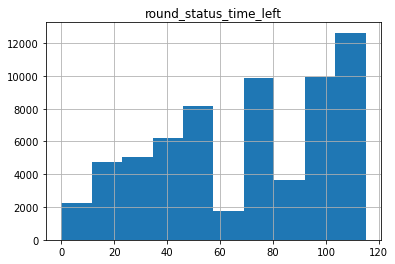

In [33]:
df.hist('round_status_time_left')

In [34]:
# even include things that didnt work?

# dummy = pd.get_dummies(df['round_status'], drop_first = True)
# df = pd.concat([df,dummy], axis = 1)

In [35]:
dummy_map = pd.get_dummies(df['map'], drop_first = False)
df = pd.concat([df,dummy_map], axis = 1)

In [36]:
df.loc[:, 'ct_score'] = df.current_score.map(lambda x: x[0])
df.loc[:, 't_score'] = df.current_score.map(lambda x: x[1])

df['score_diff'] = df['ct_score'] - df['t_score']

In [37]:
df['player_diff'] = df['alive_players_ct'] - df['alive_players_t']
df['money_diff'] = df['money_ct'] - df['money_t']

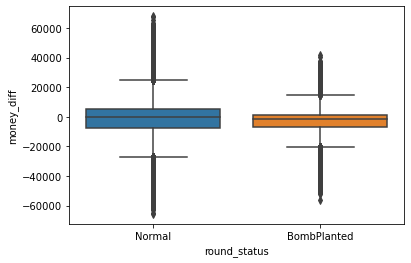

In [38]:
sns.boxplot(x = 'round_status', y = 'money_diff', data = df)

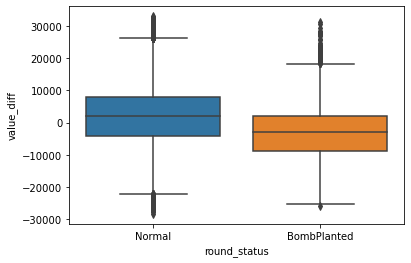

In [39]:
sns.boxplot(x = 'round_status', y = 'value_diff', data = df)

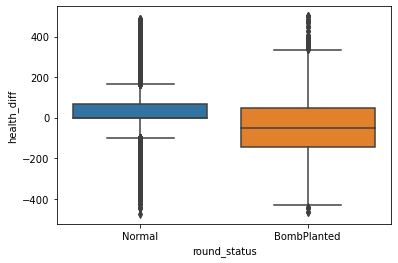

In [40]:
sns.boxplot(x = 'round_status', y = 'health_diff', data = df)

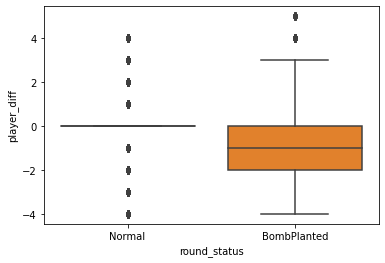

In [41]:
sns.boxplot(x = 'round_status', y = 'player_diff', data = df)

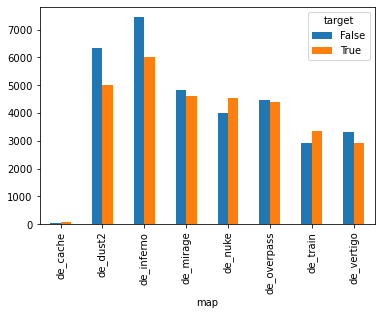

In [42]:
pd.crosstab(df.map, df.target.astype(bool)).plot(kind='bar')


In [44]:
df = df.drop(['alive_players','map', 'active_smokes', 'active_molotovs', 'previous_kills',
              'round_winner','planted_bomb','inventory_ct','inventory_t','t_items','ct_items', 
              'round_status','current_score'], axis = 1 )

In [45]:
df.head()

,round_status_time_left,target,alive_players_t,alive_players_ct,health_ct,health_t,money_ct,money_t,health_diff,total_value_ct,...,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,player_diff,money_diff
2,96.03125,1,4,4,391,400,750,500,-9,3311.0,...,0,0,0,0,0,0,0,0,0,250
3,76.03125,1,4,4,391,400,750,500,-9,3111.0,...,0,0,0,0,0,0,0,0,0,250
5,114.96875,1,5,5,500,500,1750,10550,0,18450.0,...,0,0,0,0,0,1,0,1,0,-8800
6,94.96875,1,2,3,295,111,1700,5000,184,9224.0,...,0,0,0,0,0,1,0,1,1,-3300
7,74.96875,1,2,3,295,111,1700,5000,184,9224.0,...,0,0,0,0,0,1,0,1,1,-3300


In [46]:
df.describe()

,round_status_time_left,target,alive_players_t,alive_players_ct,health_ct,health_t,money_ct,money_t,health_diff,total_value_ct,...,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,player_diff,money_diff
count,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,...,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000
mean,69.179673,0.481072,3.979174,3.996438,378.406853,365.051667,7383.410321,8739.607441,13.355185,16938.800058,...,0.146914,0.132668,0.137582,0.097813,0.097191,6.741259,6.841965,-0.100706,0.017264,-1356.197120
std,33.452756,0.499645,1.345496,1.317267,142.081558,148.858765,9268.642746,10333.622006,111.935436,9615.116000,...,0.354023,0.339218,0.344464,0.297064,0.296220,4.952320,4.900350,4.073882,1.239604,13380.118626
min,0.007812,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-475.000000,200.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-4.000000,-65750.000000
25%,35.107422,0.000000,3.000000,3.000000,291.000000,263.000000,900.000000,1200.000000,-21.000000,8144.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,-3.000000,0.000000,-7500.000000
50%,74.914060,0.000000,5.000000,5.000000,434.000000,400.000000,3900.000000,4950.000000,0.000000,17937.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,6.000000,0.000000,0.000000,-400.000000
75%,94.945310,1.000000,5.000000,5.000000,500.000000,500.000000,10650.000000,12100.000000,64.000000,25648.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,2.000000,0.000000,4650.000000
max,115.000000,1.000000,5.000000,5.000000,500.000000,500.000000,68650.000000,68300.000000,500.000000,39198.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,32.000000,33.000000,14.000000,5.000000,68000.000000


In [47]:
df.shape

(64296, 28)

In [48]:
# pair_plot = sns.pairplot(df, hue = 'target')
# pair_plot.savefig('csgo_pair')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8b3566090>]],
      dtype=object)

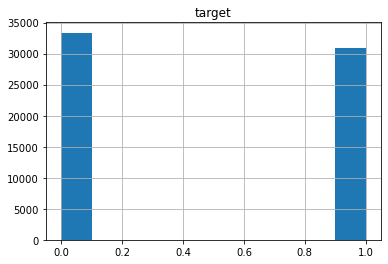

In [49]:
df.hist('target')

In [50]:
df.groupby('target').mean()

,round_status_time_left,alive_players_t,alive_players_ct,health_ct,health_t,money_ct,money_t,health_diff,total_value_ct,total_value_t,...,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,player_diff,money_diff
target,,,,,,,,,,,,,,,,,,,,,
0,66.053650,4.233149,3.668755,347.116020,384.639143,6283.581597,9788.483441,-37.523123,13716.048134,17845.644268,...,0.144822,0.119796,0.133433,0.087936,0.099475,6.448704,6.834797,-0.386093,-0.564394,-3504.901843
1,72.551687,3.705215,4.349908,412.160001,343.922828,8569.785975,7608.194045,68.237173,20415.154457,13503.029808,...,0.149171,0.146552,0.142058,0.108467,0.094727,7.056836,6.849698,0.207138,0.644693,961.591930


In [51]:
df.columns

Index(['round_status_time_left', 'target', 'alive_players_t',
       'alive_players_ct', 'health_ct', 'health_t', 'money_ct', 'money_t',
       'health_diff', 'total_value_ct', 'total_value_t', 'ct_utility',
       't_utility', 'util_diff', 'value_diff', 'de_cache', 'de_dust2',
       'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass', 'de_train',
       'de_vertigo', 'ct_score', 't_score', 'score_diff', 'player_diff',
       'money_diff'],
      dtype='object')

In [53]:
df['player_diff^1/2'] = df['player_diff'] ** (1/2)

df = df.fillna(0)


## Modeling

In [55]:
X, y = df.drop(['target', 'alive_players_ct', 'alive_players_t',
                'health_t','health_ct','t_utility','ct_utility'], axis = 1), df.target


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


In [57]:
y_test

47916    0
57089    1
35457    1
9341     0
45015    1
        ..
45864    0
14335    0
36709    1
5615     0
18308    1
Name: target, Length: 16074, dtype: int64

In [58]:
accuracy_score(y_test,np.array([0]*len(X_test)))

0.5275600348388703

In [59]:
X_train.shape

(48222, 22)

In [60]:
X_train.head()

,round_status_time_left,money_ct,money_t,health_diff,total_value_ct,total_value_t,util_diff,value_diff,de_cache,de_dust2,...,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,player_diff,money_diff,player_diff^1/2
79398,86.843750,12750,3850,-1,24008.0,24550.0,2,-542.0,0,0,...,0,0,1,0,2,0,2,0,8900,0.000000
49354,16.312500,50,1650,-84,6300.0,16685.0,2,-10385.0,0,1,...,0,0,0,0,0,1,-1,-2,-1600,0.000000
54582,34.945312,1650,9400,140,14000.0,10591.5,3,3408.5,0,0,...,0,0,0,0,7,13,-6,1,-7750,1.000000
46224,14.921875,15400,5200,162,20848.0,4767.5,1,16080.5,0,0,...,1,0,0,0,15,18,-3,3,10200,1.732051
52516,94.945310,0,9250,-178,14524.0,24347.0,-4,-9823.0,0,0,...,0,0,0,0,7,5,2,-2,-9250,0.000000


In [61]:
y_train.shape

(48222,)

In [62]:
y_train

79398    0
49354    0
54582    1
46224    1
52516    0
        ..
84934    1
51963    1
1155     0
21526    1
76630    0
Name: target, Length: 48222, dtype: int64

In [63]:
# std = StandardScaler()
# std.fit(X_train.values)
# X_tr = std.transform(X_train.values)

In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48222 entries, 79398 to 76630
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   round_status_time_left  48222 non-null  float64
 1   money_ct                48222 non-null  int64  
 2   money_t                 48222 non-null  int64  
 3   health_diff             48222 non-null  int64  
 4   total_value_ct          48222 non-null  float64
 5   total_value_t           48222 non-null  float64
 6   util_diff               48222 non-null  int64  
 7   value_diff              48222 non-null  float64
 8   de_cache                48222 non-null  uint8  
 9   de_dust2                48222 non-null  uint8  
 10  de_inferno              48222 non-null  uint8  
 11  de_mirage               48222 non-null  uint8  
 12  de_nuke                 48222 non-null  uint8  
 13  de_overpass             48222 non-null  uint8  
 14  de_train                48222 non-

In [66]:
    
models = []

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
models.append(knn)

lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
models.append(lr)
    
nb = GaussianNB()
nb.fit(X_train, y_train)
models.append(nb)

# svm = SVC(probability = True)
# svm.fit(X_train, y_train)
# models.append(svm)

rfc = RandomForestClassifier(random_state = 42, oob_score = True)
rfc.fit(X_train, y_train)
models.append(rfc)

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
models.append(gb)

xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, y_train)
models.append(xgboost)

for model in models:
        print (type(model).__name__)
        print ('Accuracy: ', accuracy_score(y_test, model.predict(X_test)))
        print('Precision: ', precision_score(y_test, model.predict(X_test)))
        print('Recall: ', recall_score(y_test, model.predict(X_test)))
        print('F1: ',f1_score(y_test, model.predict(X_test)))
        print('\n')
    
        
        
        
    

    

/home/ethan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


KNeighborsClassifier
Accuracy:  0.7317406992658952
Precision:  0.7126198497019953
Recall:  0.7242559915722939
F1:  0.7183908045977011


LogisticRegression
Accuracy:  0.737899713823566
Precision:  0.7163147792706334
Recall:  0.7371609165130366
F1:  0.7265883574534364


GaussianNB
Accuracy:  0.7381485628966032
Precision:  0.7469721289946009
Recall:  0.6740848037924677
F1:  0.7086592372118778


RandomForestClassifier
Accuracy:  0.8292273236282195
Precision:  0.8151566359027688
Recall:  0.8257835132999737
F1:  0.8204356642899195


GradientBoostingClassifier
Accuracy:  0.7529550827423168
Precision:  0.7195491455581142
Recall:  0.7818014221754016
F1:  0.7493846639318399


XGBClassifier
Accuracy:  0.7749782257061092
Precision:  0.7531508593252705
Recall:  0.7790360811166711
F1:  0.7658748139038126




In [67]:
# Accuracy log

# RandomForestClassifier
# Accuracy:  0.8284807764091079
# Precision:  0.8156898577209242
# Recall:  0.8228864893336845
# F1:  0.8192723697148475


# RandomForestClassifier
# Accuracy:  0.8269876819708847
# Precision:  0.8138776574931524
# Recall:  0.8217013431656571
# F1:  0.8177707882838608


#with dummied maps and dummied round status
#RandomForestClassifier
# Accuracy:  0.7950091575091575
# Precision:  0.7869018094975659
# Recall:  0.7988623647892578
# F1:  0.7928369811669982



# with dummied maps
# RandomForestClassifier
# Accuracy:  0.7945054945054945
# Precision:  0.7880103454646222
# Recall:  0.7955054084296904
# F1:  0.791740139211137


# with score diff
# RandomForestClassifier
# Accuracy:  0.7795787545787546
# Precision:  0.7725009221689414
# Recall:  0.7811450951137635
# F1:  0.7767989614243322



#base well not base but you know
# KNeighborsClassifier
# Accuracy:  0.7063186813186814
# Precision:  0.7024995301635031
# Recall:  0.6971279373368147
# F1:  0.6998034260039315


# LogisticRegression
# Accuracy:  0.6972527472527472
# Precision:  0.6976923076923077
# Recall:  0.6766132040283477
# F1:  0.6869911001704224


# GaussianNB
# Accuracy:  0.6993131868131868
# Precision:  0.7090415367595293
# Recall:  0.6574039537486013
# F1:  0.6822470605312817


# RandomForestClassifier
# Accuracy:  0.7737179487179487
# Precision:  0.765521675238795
# Recall:  0.7772286460276017
# F1:  0.7713307421802702


# GradientBoostingClassifier
# Accuracy:  0.7091117216117216
# Precision:  0.6907900480139677
# Recall:  0.7378776575904513
# F1:  0.7135578700572613


# XGBClassifier
# Accuracy:  0.7326923076923076
# Precision:  0.7202885482416591
# Recall:  0.7448713166728832
# F1:  0.7323737049601173


In [68]:
# for model in models:
#         print (type(model).__name__)
#         print ('Accuracy: ', accuracy_score(y_train, model.predict(X_train)))
#         print('Precision: ', precision_score(y_train, model.predict(X_train)))
#         print('Recall: ', recall_score(y_train, model.predict(X_train)))
#         print('F1: ',f1_score(y_train, model.predict(X_train)))
#         print('\n')

In [69]:
rfc.oob_score_

0.8145452283190245

KNeighborsClassifier  AUC =  0.8107193458340993
LogisticRegression  AUC =  0.8336239493318955
GaussianNB  AUC =  0.8277673209609375
RandomForestClassifier  AUC =  0.9098103067342143
GradientBoostingClassifier  AUC =  0.8513786486103725
XGBClassifier  AUC =  0.8712687927658876


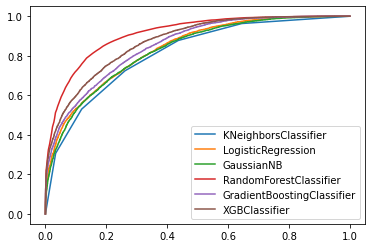

In [70]:
labels = []
for model in models:
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label = model)
    name = type(model).__name__
    print(name, " AUC = ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    labels.append(name)

plt.legend(labels = labels)

In [71]:
pprint.pprint(list(zip(X_train.columns ,rfc.feature_importances_)))

[('round_status_time_left', 0.058138757377880296),
 ('money_ct', 0.06285921062888485),
 ('money_t', 0.06295115431608499),
 ('health_diff', 0.09168043150012153),
 ('total_value_ct', 0.09443237933179041),
 ('total_value_t', 0.08447011778889563),
 ('util_diff', 0.04871005567689101),
 ('value_diff', 0.15767593185505838),
 ('de_cache', 0.00034371758918787064),
 ('de_dust2', 0.0070641569769747765),
 ('de_inferno', 0.008139270970383382),
 ('de_mirage', 0.006862355181793598),
 ('de_nuke', 0.006559613556849763),
 ('de_overpass', 0.006274441306126606),
 ('de_train', 0.005751871893749164),
 ('de_vertigo', 0.005736322194585294),
 ('ct_score', 0.03839249554555156),
 ('t_score', 0.03863571721629751),
 ('score_diff', 0.03991112853713426),
 ('player_diff', 0.06786664375934924),
 ('money_diff', 0.0650926122766143),
 ('player_diff^1/2', 0.042451614519795566)]


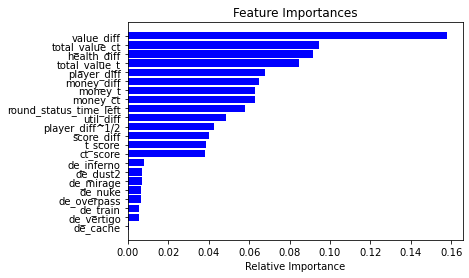

In [72]:
features = X_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [73]:
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)

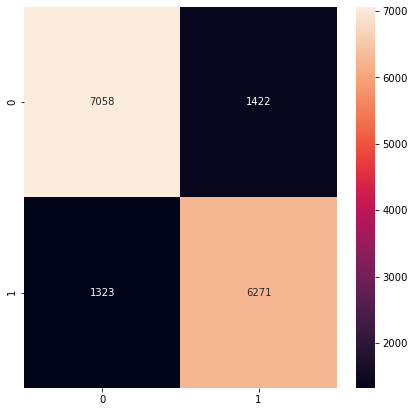

In [74]:
to_plot = confusion_matrix(y_test, pred)
plt.figure(figsize = (7,7))
sns_plot = sns.heatmap(to_plot, annot = True,fmt = 'g')
sns_plot

In [75]:
y_test = np.asarray(y_test)
misclassified = np.where(y_test != pred)

In [76]:
misclass_df =  X_test.iloc[misclassified[0],:]

In [77]:
misclass_df.shape

(2745, 22)

In [78]:
misclass_df.head()

,round_status_time_left,money_ct,money_t,health_diff,total_value_ct,total_value_t,util_diff,value_diff,de_cache,de_dust2,...,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,player_diff,money_diff,player_diff^1/2
43838,114.929690,27450,3750,0,32009.5,26550.0,6,5459.5,0,0,...,0,0,1,0,5,0,5,0,23700,0.0
40790,114.953125,750,550,0,4250.0,4050.0,-4,200.0,0,0,...,0,0,0,0,0,0,0,0,200,0.0
34176,86.875000,2650,850,-80,13400.0,13828.5,-1,-428.5,0,0,...,0,0,0,0,7,9,-2,-1,1800,0.0
62303,94.804690,600,550,-26,4400.0,3250.0,2,1150.0,0,0,...,0,0,0,0,0,0,0,0,50,0.0
36152,74.921875,2700,3550,31,23217.5,21022.0,-2,2195.5,0,0,...,0,0,0,0,14,15,-1,0,-850,0.0


In [79]:
misclass_pred = pd.Series(pred[misclassified[0]])

truth = pd.Series(y_test[misclassified[0]])

In [80]:
misclass_df['truth'] = pred[misclassified[0]]
misclass_df['misclass_pred'] = y_test[misclassified[0]]

/home/ethan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ethan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [81]:
misclass_df.head(20)

,round_status_time_left,money_ct,money_t,health_diff,total_value_ct,total_value_t,util_diff,value_diff,de_cache,de_dust2,...,de_train,de_vertigo,ct_score,t_score,score_diff,player_diff,money_diff,player_diff^1/2,truth,misclass_pred
43838,114.929690,27450,3750,0,32009.5,26550.0,6,5459.5,0,0,...,1,0,5,0,5,0,23700,0.0,1,0
40790,114.953125,750,550,0,4250.0,4050.0,-4,200.0,0,0,...,0,0,0,0,0,0,200,0.0,1,0
34176,86.875000,2650,850,-80,13400.0,13828.5,-1,-428.5,0,0,...,0,0,7,9,-2,-1,1800,0.0,0,1
62303,94.804690,600,550,-26,4400.0,3250.0,2,1150.0,0,0,...,0,0,0,0,0,0,50,0.0,1,0
36152,74.921875,2700,3550,31,23217.5,21022.0,-2,2195.5,0,0,...,0,0,14,15,-1,0,-850,0.0,0,1
7324,88.578125,300,29000,0,21300.0,26265.5,-8,-4965.5,0,0,...,0,0,5,6,-1,0,-28700,0.0,1,0
30798,90.984375,750,7250,32,20267.5,24496.0,-5,-4228.5,0,0,...,0,0,14,13,1,0,-6500,0.0,1,0
54711,38.312500,2550,650,0,5800.0,4200.0,2,1600.0,0,0,...,0,1,6,6,0,0,1900,0.0,0,1
29222,114.960940,9000,1200,0,31150.0,19450.0,5,11700.0,0,0,...,0,0,2,3,-1,0,7800,0.0,1,0
12342,74.937500,350,19950,17,13950.0,25403.0,-5,-11453.0,0,0,...,0,0,3,15,-12,0,-19600,0.0,0,1


In [82]:
misclass_df.shape

(2745, 24)

In [83]:
misclass_df.describe()

,round_status_time_left,money_ct,money_t,health_diff,total_value_ct,total_value_t,util_diff,value_diff,de_cache,de_dust2,...,de_train,de_vertigo,ct_score,t_score,score_diff,player_diff,money_diff,player_diff^1/2,truth,misclass_pred
count,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.00000,2745.000000,2745.000000,2745.000000,2745.000000,...,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000
mean,80.297441,7289.981785,8823.588342,16.605464,18979.962295,17078.78725,0.105282,1901.175046,0.001457,0.179964,...,0.096903,0.091075,6.720219,6.891803,-0.171585,0.081603,-1533.606557,0.180123,0.518033,0.481967
std,33.046679,9647.499723,10892.174120,62.033441,9305.675618,8112.31019,5.198066,7807.824177,0.038152,0.384227,...,0.295880,0.287768,4.986101,4.995656,4.142865,0.622033,14038.269388,0.404034,0.499766,0.499766
min,0.031250,0.000000,0.000000,-345.000000,200.000000,0.00000,-18.000000,-24885.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-14.000000,-3.000000,-62700.000000,0.000000,0.000000,0.000000
25%,54.929688,750.000000,1050.000000,0.000000,10650.000000,10313.50000,-3.000000,-1549.500000,0.000000,0.000000,...,0.000000,0.000000,3.000000,3.000000,-3.000000,0.000000,-7450.000000,0.000000,0.000000,0.000000
50%,94.796875,3100.000000,4200.000000,0.000000,21000.000000,18874.00000,0.000000,1532.500000,0.000000,0.000000,...,0.000000,0.000000,6.000000,6.000000,0.000000,0.000000,-300.000000,0.000000,1.000000,0.000000
75%,112.531250,10700.000000,12300.000000,41.000000,27000.000000,24296.00000,3.000000,5914.500000,0.000000,0.000000,...,0.000000,0.000000,10.000000,11.000000,2.000000,0.000000,4550.000000,0.000000,1.000000,1.000000
max,114.976560,65800.000000,63500.000000,274.000000,35600.000000,34400.00000,20.000000,31065.500000,1.000000,1.000000,...,1.000000,1.000000,30.000000,30.000000,14.000000,3.000000,62550.000000,1.732051,1.000000,1.000000


In [84]:
df.describe()

,round_status_time_left,target,alive_players_t,alive_players_ct,health_ct,health_t,money_ct,money_t,health_diff,total_value_ct,...,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,player_diff,money_diff,player_diff^1/2
count,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,...,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000,64296.000000
mean,69.179673,0.481072,3.979174,3.996438,378.406853,365.051667,7383.410321,8739.607441,13.355185,16938.800058,...,0.132668,0.137582,0.097813,0.097191,6.741259,6.841965,-0.100706,0.017264,-1356.197120,0.292201
std,33.452756,0.499645,1.345496,1.317267,142.081558,148.858765,9268.642746,10333.622006,111.935436,9615.116000,...,0.339218,0.344464,0.297064,0.296220,4.952320,4.900350,4.073882,1.239604,13380.118626,0.546113
min,0.007812,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-475.000000,200.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-4.000000,-65750.000000,0.000000
25%,35.107422,0.000000,3.000000,3.000000,291.000000,263.000000,900.000000,1200.000000,-21.000000,8144.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,-3.000000,0.000000,-7500.000000,0.000000
50%,74.914060,0.000000,5.000000,5.000000,434.000000,400.000000,3900.000000,4950.000000,0.000000,17937.000000,...,0.000000,0.000000,0.000000,0.000000,6.000000,6.000000,0.000000,0.000000,-400.000000,0.000000
75%,94.945310,1.000000,5.000000,5.000000,500.000000,500.000000,10650.000000,12100.000000,64.000000,25648.000000,...,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,2.000000,0.000000,4650.000000,0.000000
max,115.000000,1.000000,5.000000,5.000000,500.000000,500.000000,68650.000000,68300.000000,500.000000,39198.500000,...,1.000000,1.000000,1.000000,1.000000,32.000000,33.000000,14.000000,5.000000,68000.000000,2.236068


## NN

In [85]:
# def create_baseline():
#     model = Sequential()
#     model.add(Dense(10, input_dim=20, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [86]:
# estimator = KerasClassifier(build_fn=create_baseline, epochs=20, batch_size=5, verbose=1)
# kfold = StratifiedKFold(n_splits=5, shuffle=True)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# To Retry


- Grid search
- NN with more hyper parameter tuning
- Ensembling
- More feature interactions?

# To Try

- Positional data
- Reserve ammo cost
- Bomb timer
- Classify save round?
- Vectorize
- Dummy main weapon
- Clustering 
- Soft probs / confidence in pred




In [ ]:

# better vis

#reading
#sixteen zero StatHelix FACEIT 
#where the data was scraped from something rust serdas
#demo info
#bookmark those articles from history